In [7]:
# =============================================== usuals
import pandas as pd
import numpy as np

# =============================================== plot
import seaborn as sns
import matplotlib.pyplot as plt
# ============================================== Images
from PIL import Image
# =============================================== web scraping
import requests
import zipfile

from io import StringIO
from io import  BytesIO

from requests_html import HTMLSession 
from requests_html import AsyncHTMLSession
from datetime import datetime


from time import sleep
from tqdm import tqdm

# ================================================ warnings
import warnings
warnings.filterwarnings('ignore')

# **Functions**

> **Web scraping**

In [8]:
# Web scraping



def weather_series(station,years):
        session = HTMLSession() # Inicializa a classe de Requisicoes HTML
        url = 'https://portal.inmet.gov.br/dadoshistoricos'
        r = session.get(url) # Obtem as requisicoes

        # Pega todos os links de download dos arquivos com os dados climaticos historicos.
        links = [i for i in r.html.find('a') if 'https://portal.inmet.gov.br/uploads/dadoshistoricos' in str(i)]
        # <a href="https://portal.inmet.gov.br/uploads/dadoshistoricos/2001.zip">ANO 2001 (AUTOMÁTICA)</a>

        out = pd.DataFrame()
        for station in station:
            # Bloco que captura e trata os dados presentes em cada link obtido.
                for y in years:

                    url = list(filter(lambda x: str(y) in x.attrs['href'],links))[0].attrs['href'] 
                    a = BytesIO(requests.get(url).content)
                    mzip = zipfile.ZipFile(a)
                    FILE_NAME = [i.filename for i in mzip.infolist() if station in i.filename] # A001 - ESTAÇÃO DE BRASILIA
                    bytes_arq = mzip.open(name = FILE_NAME[0], mode = 'r').read()
                    string_arq = str(bytes_arq,'latin-1')
                    data = StringIO(string_arq) 
                    df_clim=pd.read_csv(data,skiprows = range(0, 8), error_bad_lines=False, encoding='latin-1',sep=';')
                    df_clim = df_clim.loc[:,~df_clim.columns.str.match("Unnamed")]


                    df_clim['Hora UTC'] = df_clim['Hora UTC'].apply(lambda x: x.replace('00 UTC',''))
                    df_clim['index'] = df_clim['Data'].astype(str)+' '+df_clim['Hora UTC'].astype(str)
                    df_clim['index'] = df_clim['index'].apply(lambda x: datetime.strptime(x,'%Y/%m/%d %H'))
                    df_clim.set_index('index',inplace=True)
                    df_clim.drop(['Data','Hora UTC'],axis=1,inplace=True)
                    df_clim = df_clim.apply(lambda x: x.apply(lambda y: str(y).replace(',','.'))) #trocar todas as virgulas por pontos
                    df_clim = df_clim.astype(float)
                
                    df_clim['CÓDIGO_ESTAÇÃO'] = station
                    out = pd.concat([out,df_clim],axis=0,ignore_index=False)
                

        New_Names=['precipitacao',
                   'pressao_instantanea',
                   'pressao_max',
                   'pressao_min',
                   'radiacao',
                   'temperatura_bulbo_seco',
                   'temperatura_orvalho_instantanea',
                   'temperatura_maxima',
                   'temperatura_minima',
                   'temperatura_maxima_orvalho',
                   'temperatura_minima_orvalho',
                   'umidade_relativa_maxima',
                   'umidade_relativa_minima',
                   'umidade_relativa_instantanea',
                    'vento_direcao', 
                    'vento_rajada',
                    'vento_velocidade', 
                    'estacao',
                    'radiacao']

        out.columns = New_Names
        return out   

In [88]:
def balance(seq):
    from collections import Counter
    
    n = len(seq)
    classes = [(clas,float(count)) for clas,count in Counter(seq).items()]
    k = len(classes)
    
    H = -sum([ (count/n) * np.log((count/n)) for clas,count in classes]) #shannon entropy
    return H/np.log(k)

> **Plots**

In [9]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=8.5):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize,fontweight='bold')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize,fontweight='bold')
    # axes.set_ylabel('True label',fontsize=fontsize)
    # axes.set_xlabel('Predicted label',fontsize=fontsize)
    axes.set_title(f"{class_label}",fontsize=fontsize,fontweight='bold')

> **Cross validation**

In [40]:
def make_df_confusion_matrix(cm,model_name):
    results = pd.DataFrame()
    for i in range(cm.shape[0]):
        col = [(model_name,i,1),(model_name,i,0)]
        idx = ['1','0']
        df = pd.DataFrame(cm[i],columns=col,index=idx)
        df.columns = pd.MultiIndex.from_tuples(df.columns)
        results = pd.concat([results,df],axis=1)
    return results

def cross_validade(model,x,y,cv,name_model,stratify = None,multi_output=False):

        # CROSS VALIDATION - BEST MODEL
        results_cv = pd.DataFrame()
        stratify_y = stratify if multi_output else y

        for idx_cv,(train_index, test_index) in enumerate(cv.split(x,stratify_y),1):
            # ============================ split data ===================================
            X_train, y_train = x.iloc[train_index],y.iloc[train_index]
            X_test, y_test = x.iloc[test_index],y.iloc[test_index]

            # ============================ train model ===================================
            model.fit(X_train, y_train)

            # ============================ predict model ===================================
            y_hat = model.predict(X_test)
            
            # ============================ classifier reports ===================================
            c_report = classification_report(y_test, y_hat,output_dict=True)
            c_report['model'] = name_model
            c_report['CV'] = idx_cv

            results_cv = results_cv.append(pd.DataFrame(c_report))

        return results_cv

# **Extraction**

In [11]:
years = [2019,2020,2021,2022]
stations = ['A047']
df_inmet = weather_series(stations,years)
df_inmet.head(3)

,precipitacao,pressao_instantanea,pressao_max,pressao_min,radiacao,temperatura_bulbo_seco,temperatura_orvalho_instantanea,temperatura_maxima,temperatura_minima,temperatura_maxima_orvalho,temperatura_minima_orvalho,umidade_relativa_maxima,umidade_relativa_minima,umidade_relativa_instantanea,vento_direcao,vento_rajada,vento_velocidade,estacao,radiacao
index,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.8,899.2,899.2,898.6,NaN,19.3,18.1,19.4,19.2,18.4,18.0,94.0,92.0,93.0,344.0,3.7,1.6,A047,NaN
2019-01-01 01:00:00,1.8,900.0,900.0,899.2,NaN,19.1,18.2,19.3,19.1,18.3,18.0,95.0,92.0,94.0,275.0,3.4,0.9,A047,NaN
2019-01-01 02:00:00,0.0,900.3,900.4,900.0,NaN,18.9,18.4,19.2,18.8,18.5,18.1,97.0,94.0,97.0,237.0,2.2,0.4,A047,NaN


In [12]:
df_vz = pd.read_csv('//srv-viacor01/pgo/PGOC/PGOCD/Paineis/13 - Machine Learning/Turbidez/rde.csv',parse_dates=['index'])
df_vz.head(3)

,index,AAB.RDE.030.FIT.001.000.000,AAB.RDE.050.FIT.001.000.000,EAB.RDE.001.CMB.001.RUN.000,EAB.RDE.001.CMB.002.RUN.000,EAB.RDE.001.CMB.003.RUN.000,EAB.RDE.001.CMB.004.RUN.000,EAB.RDE.001.CMB.005.RUN.000
0,2019-01-01 00:00:00,1920.617820,1934.765541,0.0,1.0,0.0,0.0,1.0
1,2019-01-01 01:00:00,1924.652125,1939.693707,0.0,0.0,0.0,1.0,1.0
2,2019-01-01 02:00:00,1923.320710,1938.880453,0.0,0.0,0.0,1.0,1.0


In [13]:
df = df_vz.set_index('index').join(df_inmet)
df.head(3)

,AAB.RDE.030.FIT.001.000.000,AAB.RDE.050.FIT.001.000.000,EAB.RDE.001.CMB.001.RUN.000,EAB.RDE.001.CMB.002.RUN.000,EAB.RDE.001.CMB.003.RUN.000,EAB.RDE.001.CMB.004.RUN.000,EAB.RDE.001.CMB.005.RUN.000,precipitacao,pressao_instantanea,pressao_max,...,temperatura_maxima_orvalho,temperatura_minima_orvalho,umidade_relativa_maxima,umidade_relativa_minima,umidade_relativa_instantanea,vento_direcao,vento_rajada,vento_velocidade,estacao,radiacao
index,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,1920.617820,1934.765541,0.0,1.0,0.0,0.0,1.0,0.8,899.2,899.2,...,18.4,18.0,94.0,92.0,93.0,344.0,3.7,1.6,A047,NaN
2019-01-01 01:00:00,1924.652125,1939.693707,0.0,0.0,0.0,1.0,1.0,1.8,900.0,900.0,...,18.3,18.0,95.0,92.0,94.0,275.0,3.4,0.9,A047,NaN
2019-01-01 02:00:00,1923.320710,1938.880453,0.0,0.0,0.0,1.0,1.0,0.0,900.3,900.4,...,18.5,18.1,97.0,94.0,97.0,237.0,2.2,0.4,A047,NaN


# **Understend data**

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28262 entries, 2019-01-01 00:00:00 to 2022-03-23 09:00:00
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   AAB.RDE.030.FIT.001.000.000      28262 non-null  float64
 1   AAB.RDE.050.FIT.001.000.000      28262 non-null  float64
 2   EAB.RDE.001.CMB.001.RUN.000      28261 non-null  float64
 3   EAB.RDE.001.CMB.002.RUN.000      27949 non-null  float64
 4   EAB.RDE.001.CMB.003.RUN.000      27950 non-null  float64
 5   EAB.RDE.001.CMB.004.RUN.000      28260 non-null  float64
 6   EAB.RDE.001.CMB.005.RUN.000      28051 non-null  float64
 7   precipitacao                     27748 non-null  float64
 8   pressao_instantanea              27749 non-null  float64
 9   pressao_max                      27739 non-null  float64
 10  pressao_min                      27739 non-null  float64
 11  radiacao                         4676 non-nul

In [15]:
nulos_p = (df.isna().sum()/len(df))*100
nulos_p = pd.DataFrame(nulos_p,columns=['Nulos (%)'])
nulos_p.reset_index().style.background_gradient(cmap='coolwarm')


,index,Nulos (%)
0,AAB.RDE.030.FIT.001.000.000,0.000000
1,AAB.RDE.050.FIT.001.000.000,0.000000
2,EAB.RDE.001.CMB.001.RUN.000,0.003538
3,EAB.RDE.001.CMB.002.RUN.000,1.107494
4,EAB.RDE.001.CMB.003.RUN.000,1.103956
5,EAB.RDE.001.CMB.004.RUN.000,0.007077
6,EAB.RDE.001.CMB.005.RUN.000,0.746586
7,precipitacao,1.818696
8,pressao_instantanea,1.815158
9,pressao_max,1.850541


In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AAB.RDE.030.FIT.001.000.000,28262.0,1949.098548,510.428774,0.000000,1895.074207,1931.410652,2363.832136,2814.867029
AAB.RDE.050.FIT.001.000.000,28262.0,1902.280879,530.176039,-76.440532,1833.290760,1912.622186,2319.137946,2841.926215
EAB.RDE.001.CMB.001.RUN.000,28261.0,0.432235,0.489194,0.000000,0.000000,0.000000,1.000000,1.000000
EAB.RDE.001.CMB.002.RUN.000,27949.0,0.512215,0.484975,0.000000,0.000000,0.683333,1.000000,1.000000
EAB.RDE.001.CMB.003.RUN.000,27950.0,0.013263,0.112609,0.000000,0.000000,0.000000,0.000000,1.000000
EAB.RDE.001.CMB.004.RUN.000,28260.0,0.550606,0.482187,0.000000,0.000000,1.000000,1.000000,1.000000
EAB.RDE.001.CMB.005.RUN.000,28051.0,0.615872,0.481593,0.000000,0.000000,1.000000,1.000000,1.000000
precipitacao,27748.0,0.195956,1.701481,0.000000,0.000000,0.000000,0.000000,70.200000
pressao_instantanea,27749.0,899.411557,2.600599,891.100000,897.600000,899.300000,901.100000,908.900000
pressao_max,27739.0,899.664292,2.575628,891.100000,897.900000,899.500000,901.300000,909.000000


# **EDS**

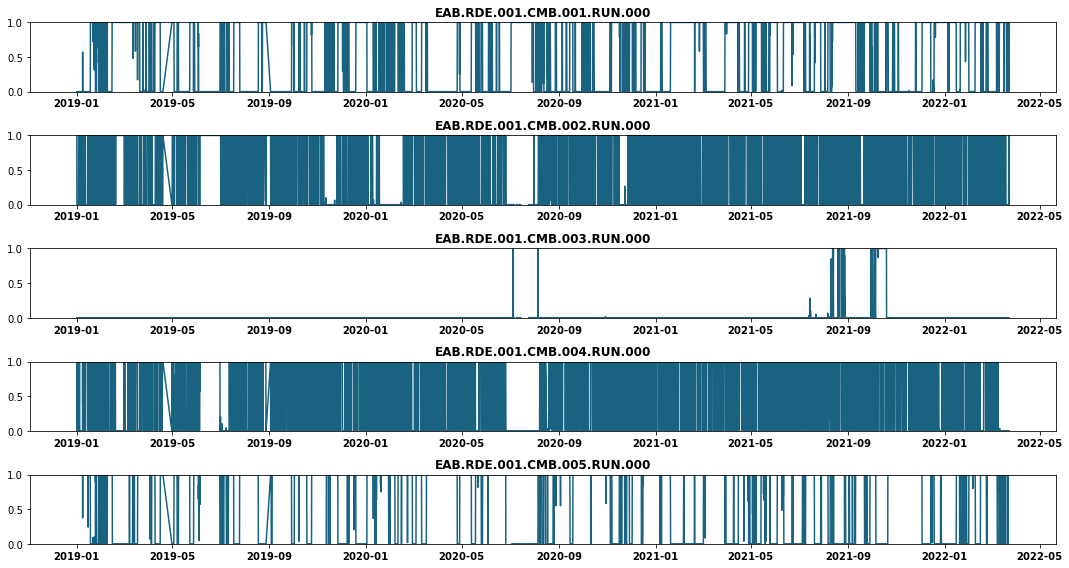

In [17]:
fig,_= plt.subplots(figsize=(15,8))

for i,c in enumerate(df.columns[df.columns.str.contains('.CMB.')],1):

  x = df.index
  y = df[c].values
  plt.subplot(5,1,i)
  plt.plot(x,y,color='#196381')
  plt.title(c,fontweight='bold')
  plt.xticks(fontweight='bold')
  plt.ylim([0,1])
fig.tight_layout()
plt.show()

In [89]:
for i in df.columns[df.columns.str.contains('CMB')]:
  classes = pd.DataFrame(df.loc[:,i].value_counts())
  bin_target = classes[(classes.index==1) | (classes.index==0)]
  print(bin_target)
  percent = (bin_target.sum().values[0]/len(df))*100
  display(f'Total:{round(percent,2)}%')


     EAB.RDE.001.CMB.001.RUN.000
0.0                        14670
1.0                        10839


'Total:96.33%'

'Balance:0.15983890885738883'

     EAB.RDE.001.CMB.002.RUN.000
1.0                        12423
0.0                        11856


'Total:91.68%'

'Balance:0.20533134864233243'

     EAB.RDE.001.CMB.004.RUN.000
1.0                        13619
0.0                        10636


'Total:91.59%'

'Balance:0.204671712249318'

     EAB.RDE.001.CMB.005.RUN.000
1.0                        15994
0.0                         9721


'Total:97.1%'

'Balance:0.1499957633723885'

In [19]:
targets_p=pd.DataFrame()
for i in df.columns[df.columns.str.contains('CMB')]:
    classes = round(df.loc[:,i],1)
    targets = classes.value_counts()
    percent = (targets/targets.sum())*100
    targets_p = pd.concat([targets_p,percent],axis=1)
display(targets_p.style.background_gradient(cmap='coolwarm'))

,EAB.RDE.001.CMB.001.RUN.000,EAB.RDE.001.CMB.002.RUN.000,EAB.RDE.001.CMB.003.RUN.000,EAB.RDE.001.CMB.004.RUN.000,EAB.RDE.001.CMB.005.RUN.000
0.000000,55.256360,45.425597,98.561717,41.564048,37.228619
1.000000,41.491808,47.028516,1.227191,50.792640,60.318705
0.800000,0.544921,1.223657,0.025045,1.323425,0.335104
0.700000,0.445844,1.531361,0.021467,1.528662,0.320844
0.600000,0.396306,1.051916,0.014311,1.167728,0.317279
0.400000,0.321999,0.651186,0.035778,0.668790,0.238851
0.200000,0.318460,0.622563,0.014311,0.605096,0.249545
0.500000,0.314922,0.855129,0.028623,0.831564,0.285195
0.900000,0.307845,0.540270,0.014311,0.470630,0.224591
0.100000,0.300768,0.522380,0.032200,0.523708,0.235286


# **Preprossessing**

In [20]:
df.drop(['radiacao'],axis=1,inplace=True)
df.drop(['estacao'],axis=1,inplace=True)
df.drop(['EAB.RDE.001.CMB.003.RUN.000'],axis=1,inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)

# **Feature selection**

> **Tukey method**

In [21]:
from statsmodels.stats.multicomp import MultiComparison
tuky_classes = df.loc[:,df.columns.str.contains('CMB')].apply(lambda med: med.apply(lambda x: 1 if x>0.3 else 0))
results_tukey = pd.DataFrame()
for i in df.columns[df.columns.str.contains('CMB')]:
    aux = pd.DataFrame()
    for l in df.columns[~df.columns.str.contains('CMB')]:
    
        mc = MultiComparison(df[l],tuky_classes[i])
        mc_results = mc.tukeyhsd()
        aux = aux.append(pd.DataFrame([[round(mc_results.pvalues[0],4),mc_results.reject[0]]], columns = [(i,'pvalues'),(i,'reject')],index=[l]))

    results_tukey = pd.concat([results_tukey,aux],axis=1)
    
results_tukey.columns = pd.MultiIndex.from_tuples(results_tukey.columns, names=['Medidor','Statistics'])

In [22]:
results_tukey.style.background_gradient(cmap='coolwarm')

# **Split data**

In [50]:
dt = df.copy()
y_dt = dt[df.columns[df.columns.str.contains('.CMB.')]]
x_dt = dt[df.columns[~df.columns.str.contains('.CMB.')]]

In [85]:
y_dt_cls = y_dt.apply(lambda c: c.apply(lambda x: 1 if x>0.3 else 0))
y_arranjo = [''.join(v) for i,v in y_dt_cls.astype(str).iterrows()]

In [100]:
for i,v in y_dt_cls.items():
  classes = pd.DataFrame(v.value_counts())
  bin_target = classes[(classes.index==1) | (classes.index==0)]
  print(bin_target)
  percent = (bin_target.sum().values[0]/len(v))*100
  print(f'Total:{round(percent,2)}%')
  print(f'Balance:{balance(v)}')

   EAB.RDE.001.CMB.001.RUN.000
0                        14921
1                        11561
Total:100.0%
Balance:0.9883562532991094
   EAB.RDE.001.CMB.002.RUN.000
1                        14126
0                        12356
Total:100.0%
Balance:0.9967751217303291
   EAB.RDE.001.CMB.004.RUN.000
1                        15371
0                        11111
Total:100.0%
Balance:0.9812521796481707
   EAB.RDE.001.CMB.005.RUN.000
1                        16544
0                         9938
Total:100.0%
Balance:0.9546355319754746


# **ML model**

In [52]:
# ======================================================= Models
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
from lightgbm import LGBMClassifier
from sklearn.multiclass import OneVsRestClassifier
# ======================================================= Select feature
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFE
# ======================================================= Pipeline
from sklearn.pipeline import Pipeline 
# ======================================================= Cross validation
from sklearn.model_selection import StratifiedKFold
# ======================================================= Metrics
from sklearn.metrics import accuracy_score,mean_absolute_error,mean_squared_error,multilabel_confusion_matrix,recall_score,precision_score,f1_score,log_loss,classification_report,hamming_loss
# =======================================================
from sklearn.model_selection import train_test_split

In [53]:
# https://github.com/catboost/tutorials/blob/94e3bc9c3510ed69c2da7f544ec8979387419ec9/classification/multilabel_classification_tutorial.ipynb

> **Models**

In [130]:
# MODELS
# ,eval_metric='HammingLoss'
ctb_logloss = CatBoostClassifier(loss_function='MultiLogloss',verbose=0)
ctbml_crossentr = CatBoostClassifier(loss_function='MultiCrossEntropy',verbose=0)
# cbc_ovr = OneVsRestClassifier(CatBoostClassifier(verbose=0))
# xgb_prox = XGBClassifier(tree_method="approx")
# xgb_hist = XGBClassifier(tree_method="hist")
# lgbm =  OneVsRestClassifier(LGBMClassifier())

> **Feature selection**

In [131]:
# PIPELINES
feature_selection = {
                        # 'XGB_conf_hist' : RFE(xgb_hist),

                        # 'XGB_conf_aprox' : RFE(xgb_prox),

                        # 'LGBM_OVR' : RFE(xgb_prox),    
    
                        'CTB_LogLoss' : RFE(ctb_logloss),
                        
                        'CTB_CrossEntropy' : RFE(ctbml_crossentr),
                                                 
                        # 'CTB_OVR' : RFE(xgb_prox)
                        
                       }

In [132]:
for k in feature_selection.keys():
    feature_selection[k].fit(x_dt,y_dt_cls)

> **Cross validation**

In [ ]:


# PIPELINES
ml_models_classifier = {
                        # 'XGB_conf_hist' : xgb_hist,

                        # 'XGB_conf_aprox' : xgb_prox,

                        # 'LGBM_OVR' : lgbm,  
                          
                        'CTB_LogLoss' : ctb_logloss,
                        
                        'CTB_CrossEntropy' : ctbml_crossentr,
                                                 
                        # 'CTB_OVR' : cbc_ovr
                        
                       }

In [ ]:


results_cv = pd.DataFrame()

for model_name in tqdm(ml_models_classifier.keys()):
    try:
        features = feature_selection[model_name].support_
        x  = x_dt.loc[:,features].copy()
    except:
        x = x_dt.copy()
        pass
    skf = StratifiedKFold(n_splits=3, random_state=43,shuffle=True)

    c_report = cross_validade(model = ml_models_classifier[model_name],
                              x = x,
                              y = y_dt_cls,
                              cv = skf,
                              name_model = model_name,
                              stratify = y_arranjo,                              
                              multi_output=True)
                            
    results_cv = results_cv.append(pd.DataFrame(c_report))

results_cv.to_csv(f'//srv-viacor01/pgo/PGOC/PGOCD/Paineis/13 - Machine Learning/Turbidez/CrossValidate/Motor/reports/cross_validation_motors.txt', header=True, index=True, sep=',', mode='w')

100%|██████████| 2/2 [02:28<00:00, 74.49s/it]


# **Results**

In [128]:
# Mean results
results = pd.read_csv('//srv-viacor01/pgo/PGOC/PGOCD/Paineis/13 - Machine Learning/Turbidez/CrossValidate/Motor/reports/cross_validation_motors.txt',index_col=[0]).reset_index()
results.drop(['CV'],axis=1,inplace=True)
results = results[results['index']!='support']
results = results.groupby(['model','index'])[results.columns].mean()
results.reset_index(inplace=True)

display(
            results[results['index']=='f1-score'].sort_values('micro avg',ascending=False).style.background_gradient(cmap='coolwarm'),
            results[results['index']=='recall'].sort_values('micro avg',ascending=False).style.background_gradient(cmap='coolwarm'),
            results[results['index']=='precision'].sort_values('micro avg',ascending=False).style.background_gradient(cmap='coolwarm'),
        )

,model,index,0,1,2,3,micro avg,macro avg,weighted avg,samples avg
0,CTB_CrossEntropy,f1-score,0.844278,0.844354,0.863335,0.910783,0.868479,0.865688,0.868483,0.846267
3,CTB_LogLoss,f1-score,0.844278,0.844354,0.863335,0.910783,0.868479,0.865688,0.868483,0.846267


,model,index,0,1,2,3,micro avg,macro avg,weighted avg,samples avg
2,CTB_CrossEntropy,recall,0.851657,0.836542,0.902088,0.913866,0.879275,0.876038,0.879275,0.857529
5,CTB_LogLoss,recall,0.851657,0.836542,0.902088,0.913866,0.879275,0.876038,0.879275,0.857529


,model,index,0,1,2,3,micro avg,macro avg,weighted avg,samples avg
1,CTB_CrossEntropy,precision,0.837045,0.852376,0.827776,0.907727,0.857948,0.856231,0.858632,0.847680
4,CTB_LogLoss,precision,0.837045,0.852376,0.827776,0.907727,0.857948,0.856231,0.858632,0.847680


# **Best model**

In [129]:
# from xgboost import XGBClassifier

# lgbm = XGBClassifier(tree_method="approx")
# # =========================== best model ====================================
# best_model = Pipeline([('RFE',RFE(ctbml)),
#                        ('CTB',lgbm)])
# # =========================== ajust ====================================
# y_dt_cls = y_dt.apply(lambda c: c.apply(lambda x: 1 if x>0.3 else 0))
# y_stratify = [''.join(v) for i,v in y_dt_cls.astype(str).iterrows()]
# # =========================== split ====================================
# X_train, X_test,y_train, y_test = train_test_split(x_dt,y_dt_cls,stratify=y_stratify)
# # =========================== train ====================================
# lgbm.fit(X_train, y_train)
# # ========================== predict ===================================
# y_hat = lgbm.predict(X_test)

# # ============================ confusion matrix ===================================
# cm = multilabel_confusion_matrix(y_test, y_hat)
# fig, ax = plt.subplots(2, 2, figsize=(5, 5))
# for axes, cfs_matrix, label in zip(ax.flatten(), cm,df.columns):
#     print_confusion_matrix(cfs_matrix, axes, label, ["N", "Y"])
# fig.tight_layout()
      
#  # ============================ classifier reports ===================================
# c_report = pd.DataFrame(classification_report(y_test, y_hat,output_dict=True))
# display(c_report)